# Lab 2: Effects of Preconditioning on the Tensile Viscoelastic Properties of Articular Cartilage

## Data Analysis

Goals for this lab report:
- For each sample, compare the properties from the first cycle of 
  preconditioning (computed from the loading phase) versus the 10th cycle of
  preconditioning.
- Determine the stiffness from the slope of the linear portion of the 
  force-displacement curve (loading only).
- Calculate the tangent elastic modulus from the stiffness
  $$k = \frac{EA}{L_0}$$
- Calculate the **work in** ($W_{in}$) from the area under the loading curve and
  the **energy recovered** ($E_{rec}$) from the area under the unloading curve.
- Calculate the percent energy recovered (quantification of hysteresis)
  $$\% E_{recovered} = 100\% \cdot \left(\frac{E_{rec}}{W_{in}}\right)$$

In [1]:
# Google Colab: Run this to mount your Google Drive
# from google.colab import drive
# import os
# drive.mount('/content/gdrive', force_remount=True)
# os.chdir('/content/gdrive/MyDrive/BMES 301/Lab 1')

# For local only
import os; os.chdir("/home/kabil/sietch/courses/bmes301/lab2")

In [2]:
# Notebook setup

%load_ext autoreload
%autoreload 2

## Import necessary libraries
### Data analysis
from scipy.signal import argrelextrema
from scipy import stats
import pandas as pd
import numpy as np

### Plotting
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

### Setup
from pathlib import Path
import re

### Custom functions
import sys; sys.path.append("../")
import tools

## Define data path
datapath = Path("data")

In [3]:
# Load data

## Regular expression to pull team information from file name
meta = re.compile(r"g(?P<team>\d{2})")

## Load all data into a list
data = []
for file in datapath.glob("lab2*.csv"):

    ## Extract sample and team information from file name
    match = meta.search(file.name)

    ## Load data
    try:
        _df = tools.load_data(file, datastart=45)
        _df['team'] = match.group('team')
        data.append(_df)
    except AssertionError as e:
        print(f"Error loading {file.name}: {e}")

## Concatenate all data into a single dataframe
raw_data = (pd.concat(data)
    .sort_values(['team', 'time'])
    .reset_index(drop=True))
display(raw_data.head())

## Load specimen dimensions
specimen = pd.read_excel(datapath / 'lab2_specimen_dimensions.xlsx')

,time,disp,load,team
0,0.0000,-1.574512,0.07,01
1,0.1464,-1.574514,0.07,01
2,0.2928,-1.574675,0.07,01
3,0.4392,-1.574714,0.05,01
4,0.5856,-1.574611,0.05,01


### Cycle Identification

In [28]:
data = []

for team in raw_data['team'].unique():
    ## Extract data for this team
    _df = (raw_data
        .query(f"team == '{team}'")
        .reset_index(drop=True))

    ## Assign cycles
    _df = tools.assign_cycles(_df)

    ## Store data and show plot
    data.append(_df)

## Concatenate all data into a single dataframe
data = pd.concat(data).reset_index(drop=True)

## Raw Data Visualization

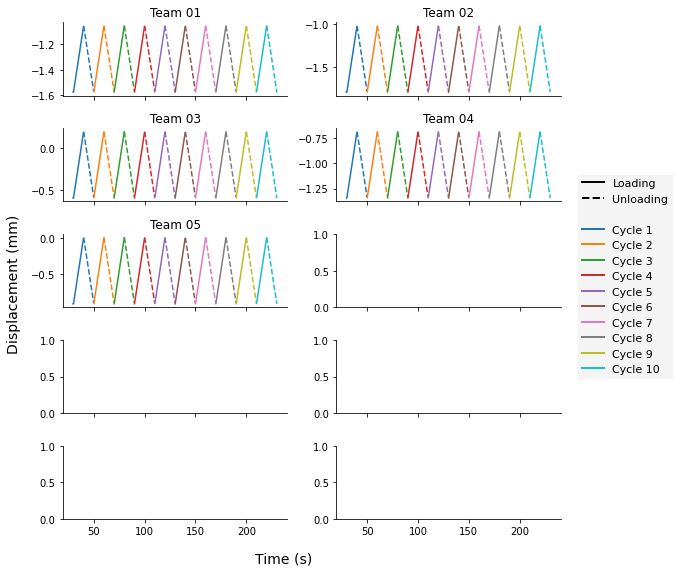

In [61]:
# Plot Displacement-time curves
fig, axes = plt.subplots(5, 2, figsize=(8, 8), sharex=True)
axes = axes.flatten()

## Cycle colors
colors = sns.color_palette("tab10", 10).as_hex()

## Create data for legend
line = lambda c, ls, x: Line2D([], [], color=c, lw=2, linestyle=ls, label=x)
legend_patches = (
    [line('black', ls, x) for ls, x in zip(['-', '--'], ['Loading', 'Unloading'])] +
    [line(None, '', '')] + 
    [line(c, '-', f"Cycle {x}") for c, x in zip(colors, range(1, 11))]
)

for i, team in enumerate(raw_data['team'].unique()):
    ## Extract data for this team
    _df = data.query(f"team == '{team}'")

    ## Plot data
    for cycle, color in zip(_df['cycle'].unique(), colors):
        for stage, ls in zip(['loading', 'unloading'], ['-', '--']):
            sns.lineplot(
                data=_df.query(f"cycle == {cycle} and stage == '{stage}'"),
                x='time', y='disp', ax=axes[i], color=color, 
                linestyle=ls, legend=False
            ).set(xlabel=None, ylabel=None)
            sns.despine()
            axes[i].set_title(f"Team {team}")
        
## Legend
fig.legend(
    handles=legend_patches, 
    loc='upper left', 
    bbox_to_anchor=(1, 0.7),
    facecolor='#f2f2f2',
    edgecolor='#ffffff',
    fancybox=False,
    fontsize=11
)

## Plot Labels
fig.subplots_adjust(left=0.15, bottom=0.15)
fig.supxlabel('Time (s)', size=14)
fig.supylabel('Displacement (mm)', size=14)
fig.tight_layout()

plt.show()